In [72]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [73]:
import numpy as np
import pandas as pd

In [74]:
import datetime

# Reflect Tables into SQLAlchemy ORM

In [75]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [76]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [77]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

In [78]:
# We can view all of the classes that automap found
inspector = inspect(engine)
stationcolumns = inspector.get_columns('station')
for column in stationcolumns:
    print(column["name"])
measurementcolumns = inspector.get_columns('measurement')
print('-------------------------------------------------------')
for column in measurementcolumns:
    print(column["name"])

id
station
name
latitude
longitude
elevation
-------------------------------------------------------
id
station
date
prcp
tobs


In [79]:
# Save references to each table


In [80]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [81]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
measurementdata = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).limit(1)
for d in measurementdata:
    lastdate = d.date
    print(lastdate)

2017-08-23


In [82]:
lastdate = datetime.datetime.strptime(lastdate, "%Y-%m-%d")
lastdate

datetime.datetime(2017, 8, 23, 0, 0)

In [83]:
from dateutil.relativedelta import relativedelta
yeardata = lastdate - relativedelta(years=1)
yeardata

datetime.datetime(2016, 8, 23, 0, 0)

In [84]:
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= lastdate, Measurement.date >= yeardata)
for d in data:
    print(d.date, d.prcp)

02
2017-06-06 0.0
2017-06-07 0.0
2017-06-08 0.01
2017-06-09 0.0
2017-06-10 0.53
2017-06-11 0.14
2017-06-12 0.35
2017-06-13 0.1
2017-06-14 0.21
2017-06-15 0.3
2017-06-16 0.02
2017-06-17 0.02
2017-06-18 0.18
2017-06-19 0.19
2017-06-20 0.17
2017-06-23 None
2017-06-26 None
2017-06-29 None
2017-06-30 0.0
2017-07-03 None
2017-07-05 None
2017-07-07 None
2017-07-08 0.06
2017-07-09 0.0
2017-07-10 0.0
2017-07-11 0.0
2017-07-12 0.02
2017-07-13 0.3
2017-07-14 0.0
2017-07-15 0.01
2017-07-16 0.12
2017-07-17 0.16
2017-07-18 0.0
2017-07-19 0.09
2017-07-20 0.0
2017-07-21 0.0
2017-07-22 0.12
2017-07-23 0.07
2017-07-24 1.19
2017-07-25 0.12
2017-07-26 0.02
2017-07-27 0.0
2017-07-28 0.14
2017-07-29 0.02
2017-07-31 None
2017-08-01 0.12
2017-08-02 0.05
2017-08-03 0.01
2017-08-04 0.04
2017-08-06 0.0
2017-08-07 0.0
2017-08-08 0.1
2017-08-09 0.0
2017-08-10 0.0
2017-08-11 0.0
2017-08-13 None
2017-08-14 0.01
2017-08-15 0.0
2017-08-16 0.0
2017-08-17 0.0
2017-08-18 0.0
2017-08-19 0.0
2017-08-20 0.01
2017-08-21 0.02

In [85]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.read_sql(data.statement, engine, index_col="date")
df.sort_index(inplace=True)
df

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


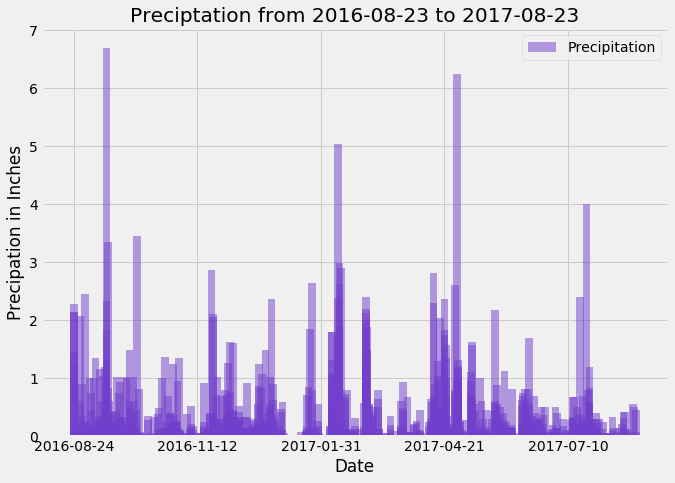

In [86]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,7))
plt.bar(df.index,df["prcp"],width=5,color='#723ecc',alpha=.5,label="Precipitation")
plt.xticks(np.arange(0,400,80))
plt.xlabel("Date")
plt.ylabel("Precipation in Inches")
plt.title(f"Preciptation from {yeardata.date()} to {lastdate.date()}")
plt.legend()
plt.show()

In [87]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df["prcp"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [88]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [89]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [90]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()

(54.0, 85.0, 71.66378066378067)

In [120]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostactivedata = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
for x in mostactivedata:
    mostactive = x

print(mostactive)

USC00519281


In [121]:
temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == mostactive).filter(Measurement.date >= yeardata)

In [122]:
for t in temps:
    print(t.date, t.tobs)

2016-08-24 77.0
2016-08-25 80.0
2016-08-26 80.0
2016-08-27 75.0
2016-08-28 73.0
2016-08-29 78.0
2016-08-30 77.0
2016-08-31 78.0
2016-09-01 80.0
2016-09-02 80.0
2016-09-03 78.0
2016-09-04 78.0
2016-09-05 78.0
2016-09-06 73.0
2016-09-07 74.0
2016-09-08 80.0
2016-09-09 79.0
2016-09-10 77.0
2016-09-11 80.0
2016-09-12 76.0
2016-09-13 79.0
2016-09-14 75.0
2016-09-15 79.0
2016-09-16 78.0
2016-09-17 79.0
2016-09-18 78.0
2016-09-19 78.0
2016-09-20 76.0
2016-09-21 74.0
2016-09-22 77.0
2016-09-23 78.0
2016-09-24 79.0
2016-09-25 79.0
2016-09-26 77.0
2016-09-27 80.0
2016-09-28 78.0
2016-09-29 78.0
2016-09-30 78.0
2016-10-01 77.0
2016-10-02 79.0
2016-10-03 79.0
2016-10-04 79.0
2016-10-05 79.0
2016-10-06 75.0
2016-10-07 76.0
2016-10-08 73.0
2016-10-09 72.0
2016-10-10 71.0
2016-10-11 77.0
2016-10-12 79.0
2016-10-13 78.0
2016-10-14 79.0
2016-10-15 77.0
2016-10-16 79.0
2016-10-17 77.0
2016-10-18 78.0
2016-10-19 78.0
2016-10-20 78.0
2016-10-21 78.0
2016-10-22 77.0
2016-10-23 74.0
2016-10-24 75.0
2016-10-

Text(0.5, 1.0, 'Temperate from 2016-08-23 to\n 2017-08-23 at Station USC00519281')

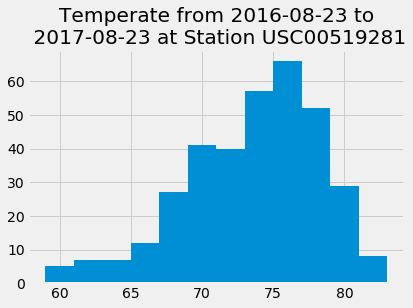

In [132]:
df2 = pd.DataFrame(temps)
plt.hist(df2["tobs"],bins=12,)
plt.title(f"Temperate from {yeardata.date()} to\n {lastdate.date()} at Station {mostactive}")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
